### POISON HUNTER IMPLEMENTATION 

## DATA PREP

Pull data from CSV

In [1]:
import pandas as pd

# Read data from CSV file instead of BigQuery
step_1_df = pd.read_csv('eth_txs.csv')

# Convert block_timestamp to datetime
step_1_df['block_timestamp'] = pd.to_datetime(step_1_df['block_timestamp'])

# Display basic info about the loaded data
print(f"Loaded {len(step_1_df):,} rows")
print(f"\nDate range: {step_1_df['block_timestamp'].min()} to {step_1_df['block_timestamp'].max()}")
print(f"\nToken addresses: {step_1_df['token_address'].unique()}")
step_1_df.head()

Loaded 3,906,800 rows

Date range: 2024-07-15 00:00:11+00:00 to 2024-07-31 23:59:59+00:00

Token addresses: ['0xdac17f958d2ee523a2206206994597c13d831ec7'
 '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48']


,block_number,block_timestamp,token_address,from_address,to_address,value,value_usd,transaction_hash
0,20369835,2024-07-23 14:29:35+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0xb209f36278decb047509013e26b04fadf913bd23,0x63f5a5b8726232a221a2ca5e6fb94f3f3918d01a,598813000000,598813.00,0xce291ac056d2db6fe01e6b4df64847bbc825dbcabeb1...
1,20369835,2024-07-23 14:29:35+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0xa476e795c48f7672ba3253c17974c40c15e0ca3a,0x97ab071b739ccec63733194be937a6bf160a9c08,146880000,146.88,0x52e9d8dc47a6a0866e4e6952bd2554997ed903cf6225...
2,20369835,2024-07-23 14:29:35+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xcd4873931dbd9928866bac81a76930cfac3cb77d,0xf6080d9fbeebcd44d89affbfd42f098cbff92816,39986700000,39986.70,0x6b05633a1032be56a2a3943d2ae1395b3378f7b14a6c...
3,20369835,2024-07-23 14:29:35+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0x6f5f545b93f30bfb13ccbe4ee8923a437f5d49b9,0x28d074c8df8d54fb354a34579bc2104f672d31fb,11380000,11.38,0x0664ea9c0a8395e9c7412e06159cc867cdae67ec414f...
4,20369835,2024-07-23 14:29:35+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0x2bd617ad6e62e26a18c339ae929f2187acb0efaa,0x8546690072aa077e67be07020ca83e726046d069,14440000,14.44,0x36fd637c2d80dbf28f2c955c99d083532d5e191b3779...


Step 1 Filtering

In [2]:
import pandas as pd

min_block = step_1_df['block_number'].min()
max_block = step_1_df['block_number'].max()

def filter_by_block(start_block: int, end_block: int, df: pd.DataFrame = step_1_df) -> pd.DataFrame:
    """
    Filters a pandas DataFrame by block_number range and returns a new DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame containing a 'block_number' column.
        start_block (int): Minimum block_number (inclusive).
        end_block (int): Maximum block_number (inclusive).

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    # Ensure block_number column exists
    if 'block_number' not in df.columns:
        raise ValueError("DataFrame must contain a 'block_number' column.")
    
    filtered_df = df[(df['block_number'] >= start_block) & (df['block_number'] <= end_block)]
    return filtered_df

In [3]:
print(f"min block: {min_block}")
print(f"max block: {max_block}")

min block: 20308187
max block: 20429972


Step2 Functions

In [4]:
import pandas as pd
import numpy as np
from typing import Set, Any
# takes a window of transactions and a block with the original txn & identifies all zero-value and tiny-dusty attack
def step2_vectorized(window_dataframe, block_1):
    
    victim_set = set(block_1['from_address'])
    
    # Build victim -> tx_hashes mapping
    victim_to_tx_hashes = block_1.groupby('from_address')['transaction_hash'].apply(set).to_dict()
    
    # Vectorized conditions
    mask_zero = (window_dataframe['value_usd'] == 0) & (window_dataframe['from_address'].isin(victim_set))
    mask_dust = (window_dataframe['value_usd'] > 0) & (window_dataframe['value_usd'] <= 1) & (window_dataframe['to_address'].isin(victim_set))
    
    combined_mask = mask_zero | mask_dust
    
    # Early return if no matches
    if not combined_mask.any():
        return pd.DataFrame(columns=list(window_dataframe.columns) + ['attacker_address', 'victim_address', 'victim_tx_hash', 'attack_type'])
    
    # Filter matching rows
    suspicious_transactions = window_dataframe[combined_mask].copy()
    
    # Get the mask subset for proper alignment
    mask_zero_subset = mask_zero[combined_mask]
    
    # Set attacker address based on which condition matched
    suspicious_transactions['attacker_address'] = np.where(
        mask_zero_subset,
        suspicious_transactions['to_address'],
        suspicious_transactions['from_address']
    )
    
    # Set victim address (opposite of attacker)
    suspicious_transactions['victim_address'] = np.where(
        mask_zero_subset,
        suspicious_transactions['from_address'],
        suspicious_transactions['to_address']
    )
    
    # Set victim tx hash using the mapping
    suspicious_transactions['victim_tx_hash'] = suspicious_transactions['victim_address'].map(
        lambda addr: victim_to_tx_hashes.get(addr, set())
    )
    
    # Set attack type
    suspicious_transactions['attack_type'] = np.where(
        mask_zero_subset,
        'zero',
        'dust'
    )
    
    return suspicious_transactions

Step 2: Execut on data

In [5]:
BLOCK_WDOW = 100
# transaction_set = step_1_df
import time

start = time.time()  # record start time
sus_txns = []
print(f"started at {start}")
for block_num in range(min_block,min_block+1000):
    victim_block = filter_by_block(block_num,block_num)
    search_window = filter_by_block(block_num+1,block_num+BLOCK_WDOW+1)
    new_df = step2_vectorized(search_window, victim_block)
    if not new_df.empty:
        sus_txns.append(new_df)
end = time.time()    # record end time
combined_df_vector = pd.concat(sus_txns, ignore_index=True)
print(f"end time: {end}")
print(f"time elapsed: {end-start}")

started at 1764560730.512876
end time: 1764560740.000182
time elapsed: 9.487305879592896


In [6]:
combined_df_vector.sort_values(
    by="transaction_hash",
    key=lambda col: col.astype(str)
).reset_index(drop=True).shape

(1787, 12)

Step 2: victim mapping

In [7]:
import numpy as np
import pandas as pd
import time
from tqdm.auto import tqdm

# -------------------------------
# 1. DEFINE THE BLOCK RANGE
# -------------------------------
start = time.time()  # record start time
NUM_BLOCKS = 1000
victim_blocks = np.arange(min_block, min_block + NUM_BLOCKS)

# Victim df = all transactions in those blocks
victim_df = step_1_df[step_1_df['block_number'].isin(victim_blocks)].copy()

# Window df = all transactions that could appear in any search window
search_min = min_block + 1
search_max = (min_block + NUM_BLOCKS - 1) + BLOCK_WDOW + 1 

window_df = step_1_df[
    (step_1_df['block_number'] >= search_min) &
    (step_1_df['block_number'] <= search_max)
].copy()


# ----------------------------------------
# 1. BUILD MAPPING: search_block → victim_block(s)
# ----------------------------------------
# For each unique search block in window_df, compute which victim blocks it should pair with.
print("Building block mapping...")
search_unique_blocks = window_df['block_number'].unique()

# For each search block B_s, valid victims satisfy:
#   B_v ∈ [B_s - BLOCK_WDOW, B_s - 1]
#   and B_v is within our victim range
mapping_rows = []
for b_s in tqdm(search_unique_blocks, desc="Mapping blocks"):
    v_low = b_s - BLOCK_WDOW - 1  # changed from b_s - BLOCK_WDOW
    v_high = b_s - 1

    # intersect with our victim blocks
    valid_victims = victim_blocks[
        (victim_blocks >= v_low) & (victim_blocks <= v_high)
    ]

    for v in valid_victims:
        mapping_rows.append((b_s, v))

block_map = pd.DataFrame(mapping_rows, columns=['search_block', 'victim_block'])

# ----------------------------------------
# 2. MERGE THE MAPPING WITH window_df
# ----------------------------------------
# Many window_df rows share the same block → they will inherit the same victim_block list
window_df2 = window_df.merge(
    block_map,
    left_on='block_number',
    right_on='search_block',
    how='right'
)

# Clean up helper col
window_df2 = window_df2.drop(columns=['search_block'])

# ----------------------------------------
# 3. FOR EACH victim_block, extract its victims
# ----------------------------------------
# This avoids millions of repeated filters.
victim_groups = {
    blk: grp for blk, grp in victim_df.groupby('block_number')
}

# ----------------------------------------
# 4. RUN step2_vectorized in BULK
# ----------------------------------------
# We now have a single giant window table, but rows know their victim_block.
print("\nProcessing victim blocks...")
results = []
grouped = list(window_df2.groupby('victim_block'))

for v_block, win_grp in tqdm(grouped, desc="Scanning for attacks"):
    victim_block_df = victim_groups.get(v_block)
    if victim_block_df is None:
        continue

    out = step2_vectorized(win_grp, victim_block_df)
    if not out.empty:
        out['victim_block_number'] = v_block
        results.append(out)

# Final output = merged suspicious transactions across ALL blocks
step_2_df = pd.concat(results, ignore_index=True) if results else pd.DataFrame()
end = time.time()  # record start time
print(f"\nStep 2 completed for {NUM_BLOCKS} blocks in {end-start:.2f} seconds")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Building block mapping...


Mapping blocks: 100%|██████████| 1099/1099 [00:00<00:00, 19046.51it/s]



Processing victim blocks...


Scanning for attacks: 100%|██████████| 1000/1000 [00:01<00:00, 934.13it/s]



Step 2 completed for 1000 blocks in 1.67 seconds


In [8]:
step_2_df.shape

(1787, 14)

Step 3: helper functions

In [9]:
from typing import Tuple, Set, Dict

def calculate_similarity_score(addr1: str, addr2: str) -> Tuple[int, int]:
    """
    Calculate prefix and suffix match length between two addresses.
    Case-insensitive comparison, ignores '0x' prefix.
    
    Args:
        addr1: First Ethereum address
        addr2: Second Ethereum address
    
    Returns:
        (prefix_match_length, suffix_match_length)
    """
    addr1 = addr1.lower()
    addr2 = addr2.lower()
    
    # Remove '0x' prefix if present
    if addr1.startswith('0x'):
        addr1 = addr1[2:]
    if addr2.startswith('0x'):
        addr2 = addr2[2:]
    
    # Calculate prefix match
    prefix_match = 0
    for c1, c2 in zip(addr1, addr2):
        if c1 == c2:
            prefix_match += 1
        else:
            break
    
    # Calculate suffix match
    suffix_match = 0
    for c1, c2 in zip(reversed(addr1), reversed(addr2)):
        if c1 == c2:
            suffix_match += 1
        else:
            break
    
    return prefix_match, suffix_match



Step 3: code

In [10]:
def step3_extract_lookalikes_optimized(
    step2_df: pd.DataFrame,
    original_df: pd.DataFrame,
    min_prefix: int = 3,
    min_suffix: int = 4,
    show_progress: bool = True
) -> pd.DataFrame:
    """
    Extract lookalike addresses from step2 output.
    Uses victim_tx_hash from step2_df to find intended addresses from original transactions.
    
    Args:
        step2_df: Output DataFrame from step2 with attacker_address, victim_address, victim_tx_hash columns
        original_df: Original transaction DataFrame (step_1_df) containing transaction_hash -> to_address mapping
        min_prefix: Minimum prefix match length (default 3)
        min_suffix: Minimum suffix match length (default 4)
        show_progress: Whether to show progress bar
    
    Returns:
        DataFrame with lookalike analysis including similarity scores
    """
    from tqdm.auto import tqdm
    
    new_columns = ['intended_address', 'prefix_match', 'suffix_match', 'attacker_transaction_hash', 'victim_transaction_hash', 'time_since_victim_tx', 'is_lookalike']
    
    if step2_df.empty:
        return pd.DataFrame(columns=list(step2_df.columns) + new_columns)
    
    # Build transaction_hash -> to_address mapping from original data
    tx_hash_to_recipient = original_df.set_index('transaction_hash')['to_address'].to_dict()
    
    # Build transaction_hash -> block_timestamp mapping for time delta calculation
    tx_hash_to_timestamp = original_df.set_index('transaction_hash')['block_timestamp'].to_dict()
    
    # Get unique (attacker, victim_tx_hash) pairs for efficient computation
    unique_pairs = step2_df[['attacker_address', 'victim_address', 'victim_tx_hash']].drop_duplicates(
        subset=['attacker_address', 'victim_address']
    )
    
    # Compute best matches for each unique pair
    results = []
    iterator = unique_pairs.iterrows()
    if show_progress:
        iterator = tqdm(list(iterator), desc="Analyzing lookalikes")
    
    for _, row in iterator:
        attacker = row['attacker_address']
        victim = row['victim_address']
        victim_tx_hashes = row['victim_tx_hash']
        
        # Get intended addresses from victim's transaction hashes
        intended_set = {tx_hash_to_recipient.get(tx_hash) for tx_hash in victim_tx_hashes if tx_hash in tx_hash_to_recipient}
        intended_set.discard(None)  # Remove any None values
        
        best_intended = None
        best_prefix = 0
        best_suffix = 0
        
        for intended in intended_set:
            p, s = calculate_similarity_score(attacker, intended)
            if (p + s) > (best_prefix + best_suffix):
                best_intended = intended
                best_prefix = p
                best_suffix = s
        
        # Find earliest victim transaction timestamp
        victim_timestamps = [tx_hash_to_timestamp.get(tx_hash) for tx_hash in victim_tx_hashes if tx_hash in tx_hash_to_timestamp]
        earliest_victim_ts = min(victim_timestamps) if victim_timestamps else None
        
        results.append({
            'attacker_address': attacker,
            'victim_address': victim,
            'intended_address': best_intended,
            'prefix_match': best_prefix,
            'suffix_match': best_suffix,
            'victim_timestamp': earliest_victim_ts
        })
    
    # Create lookup DataFrame
    lookup_df = pd.DataFrame(results)
    
    # Merge with original step2_df
    result_df = step2_df.merge(
        lookup_df,
        on=['attacker_address', 'victim_address'],
        how='left'
    )
    
    # Add attacker_transaction_hash (the attacking/suspicious transaction)
    result_df['attacker_transaction_hash'] = result_df['transaction_hash']
    
    # Add victim_transaction_hash (copy of victim_tx_hash for clarity)
    result_df['victim_transaction_hash'] = result_df['victim_tx_hash']
    
    # Calculate time since victim transaction (attack timestamp - victim timestamp)
    result_df['time_since_victim_tx'] = result_df['block_timestamp'] - result_df['victim_timestamp']
    
    # Add is_lookalike flag
    result_df['is_lookalike'] = (
        (result_df['prefix_match'] >= min_prefix) & 
        (result_df['suffix_match'] >= min_suffix)
    )
    
    return result_df

Step 3: execute

In [11]:
# Run Step 3 - now uses victim_tx_hash from step2_df to find intended addresses
step_3_df = step3_extract_lookalikes_optimized(
    step2_df=step_2_df,
    original_df=step_1_df,  # Pass original transaction data for tx_hash -> to_address lookup
    min_prefix=3,
    min_suffix=4
)

# Filter to confirmed attacks only
confirmed_attacks = step_3_df[step_3_df['is_lookalike'] == True]

print(f"Total suspicious: {len(step_3_df)}")
print(f"Confirmed lookalikes: {len(confirmed_attacks)}")

Analyzing lookalikes: 100%|██████████| 228/228 [00:00<00:00, 63259.99it/s]

Total suspicious: 1787
Confirmed lookalikes: 193


In [12]:
confirmed_attacks

,block_number,block_timestamp,token_address,from_address,to_address,value,value_usd,transaction_hash,victim_block,attacker_address,...,attack_type,victim_block_number,intended_address,prefix_match,suffix_match,victim_timestamp,attacker_transaction_hash,victim_transaction_hash,time_since_victim_tx,is_lookalike
6,20308221,2024-07-15 00:06:59+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x1111111254eeb25477b68fb85ed929f73a960582,0xa7ca2c8673bcfa5a26d8ceec2887f2cc2b0db22a,599,0.000599,0x7786d61d9928daa84ff4f77a426abeb333b71dfe379b...,20308195,0x1111111254eeb25477b68fb85ed929f73a960582,...,dust,20308195,0x1111111254eeb25477b68fb85ed929f73a960582,40,40,2024-07-15 00:01:47+00:00,0x7786d61d9928daa84ff4f77a426abeb333b71dfe379b...,{0xc2c8710cc723df8626fcd53b00fe73e3b9583f3b018...,0 days 00:05:12,True
11,20308206,2024-07-15 00:03:59+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x4ca5d026bbc7435cde97365d22d010754b5174d0,0x7110c32d2e5c445575676ba582fe5048977de557,200000,0.200000,0xe1197fc00e5e433122bb34d879ba6d78b94f77539f04...,20308197,0x4ca5d026bbc7435cde97365d22d010754b5174d0,...,dust,20308197,0x4ca5f4b078ff985d31b6b66a74415379547174d0,4,5,2024-07-15 00:02:11+00:00,0xe1197fc00e5e433122bb34d879ba6d78b94f77539f04...,{0xae5c146ce9229f74d3dd006cd28dc977c1884824201...,0 days 00:01:48,True
24,20308227,2024-07-15 00:08:11+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0x934b75fed568acaf759926f33a6919c546834187,0x03e6da83cc595976a18c6768c7aad85cfbefd062,0,0.000000,0x6c6d10584a338c27183ce87267faab19e08b92e54a31...,20308205,0x03e6da83cc595976a18c6768c7aad85cfbefd062,...,zero,20308205,0x03e6dc894c0670947ac9237e263519c9a00dd062,5,4,2024-07-15 00:03:47+00:00,0x6c6d10584a338c27183ce87267faab19e08b92e54a31...,{0x93d6a3d617d5d96f080fb8dcacf7239edcf6d08db93...,0 days 00:04:24,True
25,20308285,2024-07-15 00:19:59+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0x03e6d44fe0407b872728a9517655c82a240dd062,0x934b75fed568acaf759926f33a6919c546834187,100100,0.100100,0x57a696b561ebc3f69caf013389a1a8e0753e84a37d2a...,20308205,0x03e6d44fe0407b872728a9517655c82a240dd062,...,dust,20308205,0x03e6dc894c0670947ac9237e263519c9a00dd062,5,6,2024-07-15 00:03:47+00:00,0x57a696b561ebc3f69caf013389a1a8e0753e84a37d2a...,{0x93d6a3d617d5d96f080fb8dcacf7239edcf6d08db93...,0 days 00:16:12,True
43,20308227,2024-07-15 00:08:11+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0xe9f773b5091dda32403829e8326ff6e69361d876,0x3ff138569dd22125e13febd97e36915ec77f91dd,0,0.000000,0x6c6d10584a338c27183ce87267faab19e08b92e54a31...,20308219,0x3ff138569dd22125e13febd97e36915ec77f91dd,...,zero,20308219,0x3fff5d97ca1d6e1746c3a954e67825da167f91dd,3,6,2024-07-15 00:06:35+00:00,0x6c6d10584a338c27183ce87267faab19e08b92e54a31...,{0x966f945b56a1a3f0f022c5fad972d37d20acc001991...,0 days 00:01:36,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,20309206,2024-07-15 03:24:35+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0xe20f59069ba8c5a9c5c946db38cf7677f3d075c2,0x9387fbdc08c6c91680a115a04ae3e04c8af77a2a,0,0.000000,0xd57a1910ed1d82328e9e09b9ce42fcdc7f2b6c4771b6...,20309177,0x9387fbdc08c6c91680a115a04ae3e04c8af77a2a,...,zero,20309177,0x9387f3638e6f64e6562c6e3aace5243866be7a2a,5,4,2024-07-15 03:18:47+00:00,0xd57a1910ed1d82328e9e09b9ce42fcdc7f2b6c4771b6...,{0x72e72e7cdc77fbc35866f5513ff13ececb69945a93b...,0 days 00:05:48,True
1767,20309206,2024-07-15 03:24:35+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xfb06fcd4a06903e71404e0cbda4aaad9019ff96c,0x3bbe729f43f092b71002340bd612b3f7929c0f16,0,0.000000,0xd57a1910ed1d82328e9e09b9ce42fcdc7f2b6c4771b6...,20309177,0x3bbe729f43f092b71002340bd612b3f7929c0f16,...,zero,20309177,0x3bbed24541729758a64c452eff55491dbf870f16,4,4,2024-07-15 03:18:47+00:00,0xd57a1910ed1d82328e9e09b9ce42fcdc7f2b6c4771b6...,{0xbdbaebce571ea1b003bdefc59a4c25574915ab7ec4e...,0 days 00:05:48,True
1768,20309187,2024-07-15 03:20:47+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa4c79bbeded59b72a764991de1b576dc3c90fa0b,0xed62e6fe4f20

## Step 4: Post Processing

Filter out false positives where the attacker address fully matches the intended address.


In [13]:
# Filter out instances where prefix_match or suffix_match is 40 (full address match = likely false positive)
# An Ethereum address has 40 hex characters (excluding '0x'), so 40 = complete match

before_count = len(confirmed_attacks)

# Keep only rows where NEITHER prefix_match NOR suffix_match equals 40
filtered_attacks = confirmed_attacks[
    (confirmed_attacks['prefix_match'] != 40) & 
    (confirmed_attacks['suffix_match'] != 40)
].copy()

after_count = len(filtered_attacks)

print(f"Before filtering: {before_count} confirmed attacks")
print(f"Removed: {before_count - after_count} rows with full address overlap (40 chars)")
print(f"After filtering: {after_count} confirmed attacks")

filtered_attacks


Before filtering: 193 confirmed attacks
Removed: 5 rows with full address overlap (40 chars)
After filtering: 188 confirmed attacks


,block_number,block_timestamp,token_address,from_address,to_address,value,value_usd,transaction_hash,victim_block,attacker_address,...,attack_type,victim_block_number,intended_address,prefix_match,suffix_match,victim_timestamp,attacker_transaction_hash,victim_transaction_hash,time_since_victim_tx,is_lookalike
11,20308206,2024-07-15 00:03:59+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0x4ca5d026bbc7435cde97365d22d010754b5174d0,0x7110c32d2e5c445575676ba582fe5048977de557,200000,0.2000,0xe1197fc00e5e433122bb34d879ba6d78b94f77539f04...,20308197,0x4ca5d026bbc7435cde97365d22d010754b5174d0,...,dust,20308197,0x4ca5f4b078ff985d31b6b66a74415379547174d0,4,5,2024-07-15 00:02:11+00:00,0xe1197fc00e5e433122bb34d879ba6d78b94f77539f04...,{0xae5c146ce9229f74d3dd006cd28dc977c1884824201...,0 days 00:01:48,True
24,20308227,2024-07-15 00:08:11+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0x934b75fed568acaf759926f33a6919c546834187,0x03e6da83cc595976a18c6768c7aad85cfbefd062,0,0.0000,0x6c6d10584a338c27183ce87267faab19e08b92e54a31...,20308205,0x03e6da83cc595976a18c6768c7aad85cfbefd062,...,zero,20308205,0x03e6dc894c0670947ac9237e263519c9a00dd062,5,4,2024-07-15 00:03:47+00:00,0x6c6d10584a338c27183ce87267faab19e08b92e54a31...,{0x93d6a3d617d5d96f080fb8dcacf7239edcf6d08db93...,0 days 00:04:24,True
25,20308285,2024-07-15 00:19:59+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0x03e6d44fe0407b872728a9517655c82a240dd062,0x934b75fed568acaf759926f33a6919c546834187,100100,0.1001,0x57a696b561ebc3f69caf013389a1a8e0753e84a37d2a...,20308205,0x03e6d44fe0407b872728a9517655c82a240dd062,...,dust,20308205,0x03e6dc894c0670947ac9237e263519c9a00dd062,5,6,2024-07-15 00:03:47+00:00,0x57a696b561ebc3f69caf013389a1a8e0753e84a37d2a...,{0x93d6a3d617d5d96f080fb8dcacf7239edcf6d08db93...,0 days 00:16:12,True
43,20308227,2024-07-15 00:08:11+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0xe9f773b5091dda32403829e8326ff6e69361d876,0x3ff138569dd22125e13febd97e36915ec77f91dd,0,0.0000,0x6c6d10584a338c27183ce87267faab19e08b92e54a31...,20308219,0x3ff138569dd22125e13febd97e36915ec77f91dd,...,zero,20308219,0x3fff5d97ca1d6e1746c3a954e67825da167f91dd,3,6,2024-07-15 00:06:35+00:00,0x6c6d10584a338c27183ce87267faab19e08b92e54a31...,{0x966f945b56a1a3f0f022c5fad972d37d20acc001991...,0 days 00:01:36,True
50,20308285,2024-07-15 00:19:59+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0x03e6d44fe0407b872728a9517655c82a240dd062,0x934b75fed568acaf759926f33a6919c546834187,100100,0.1001,0x57a696b561ebc3f69caf013389a1a8e0753e84a37d2a...,20308227,0x03e6d44fe0407b872728a9517655c82a240dd062,...,dust,20308227,0x03e6dc894c0670947ac9237e263519c9a00dd062,5,6,2024-07-15 00:03:47+00:00,0x57a696b561ebc3f69caf013389a1a8e0753e84a37d2a...,{0x6c6d10584a338c27183ce87267faab19e08b92e54a3...,0 days 00:16:12,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,20309206,2024-07-15 03:24:35+00:00,0xdac17f958d2ee523a2206206994597c13d831ec7,0xe20f59069ba8c5a9c5c946db38cf7677f3d075c2,0x9387fbdc08c6c91680a115a04ae3e04c8af77a2a,0,0.0000,0xd57a1910ed1d82328e9e09b9ce42fcdc7f2b6c4771b6...,20309177,0x9387fbdc08c6c91680a115a04ae3e04c8af77a2a,...,zero,20309177,0x9387f3638e6f64e6562c6e3aace5243866be7a2a,5,4,2024-07-15 03:18:47+00:00,0xd57a1910ed1d82328e9e09b9ce42fcdc7f2b6c4771b6...,{0x72e72e7cdc77fbc35866f5513ff13ececb69945a93b...,0 days 00:05:48,True
1767,20309206,2024-07-15 03:24:35+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xfb06fcd4a06903e71404e0cbda4aaad9019ff96c,0x3bbe729f43f092b71002340bd612b3f7929c0f16,0,0.0000,0xd57a1910ed1d82328e9e09b9ce42fcdc7f2b6c4771b6...,20309177,0x3bbe729f43f092b71002340bd612b3f7929c0f16,...,zero,20309177,0x3bbed24541729758a64c452eff55491dbf870f16,4,4,2024-07-15 03:18:47+00:00,0xd57a1910ed1d82328e9e09b9ce42fcdc7f2b6c4771b6...,{0xbdbaebce571ea1b003bdefc59a4c25574915ab7ec4e...,0 days 00:05:48,True
1768,20309187,2024-07-15 03:20:47+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xa4c79bbeded59b72a764991de1b576dc3c90fa0b,0xed62e6fe4f20e60514ea25f9

## Step 5: Determine Successful Attacks

An attack is considered **successful** if the victim later sent a non-zero amount to the attacker's address (meaning they mistakenly copied the poisoned address instead of their intended recipient).


In [14]:
from tqdm.auto import tqdm

def find_successful_attacks(
    attacks_df: pd.DataFrame,
    all_transfers_df: pd.DataFrame,
    show_progress: bool = True
) -> pd.DataFrame:
    """
    Determine which attacks were successful by checking if the victim
    later sent a non-zero amount to the attacker's address.
    
    Args:
        attacks_df: DataFrame of confirmed attacks with attacker_address, victim_address, block_timestamp
        all_transfers_df: Original transaction DataFrame (step_1_df) to search for victim->attacker transfers
        show_progress: Whether to show progress bar
    
    Returns:
        DataFrame with additional columns: is_successful, success_tx_hash, success_value_usd, success_timestamp
    """
    if attacks_df.empty:
        attacks_df['is_successful'] = False
        attacks_df['success_tx_hash'] = None
        attacks_df['success_value_usd'] = None
        attacks_df['success_timestamp'] = None
        return attacks_df
    
    result_df = attacks_df.copy()
    
    # Initialize new columns
    result_df['is_successful'] = False
    result_df['success_tx_hash'] = None
    result_df['success_value_usd'] = None
    result_df['success_timestamp'] = None
    
    # Get unique (victim, attacker) pairs to avoid redundant searches
    unique_pairs = result_df[['victim_address', 'attacker_address']].drop_duplicates()
    
    # Build a lookup for victim->attacker transfers (non-zero value)
    # Filter all_transfers_df for potential success transactions
    potential_success = all_transfers_df[all_transfers_df['value_usd'] > 0].copy()
    
    # Create a mapping: (from_address, to_address) -> list of (tx_hash, value_usd, timestamp)
    success_lookup = {}
    
    iterator = unique_pairs.iterrows()
    if show_progress:
        iterator = tqdm(list(iterator), desc="Checking for successful attacks")
    
    for _, pair in iterator:
        victim = pair['victim_address']
        attacker = pair['attacker_address']
        
        # Find transfers where victim sent to attacker
        matches = potential_success[
            (potential_success['from_address'] == victim) & 
            (potential_success['to_address'] == attacker)
        ]
        
        if not matches.empty:
            # Get the first (or largest) successful transfer
            best_match = matches.loc[matches['value_usd'].idxmax()]
            success_lookup[(victim, attacker)] = {
                'tx_hash': best_match['transaction_hash'],
                'value_usd': best_match['value_usd'],
                'timestamp': best_match['block_timestamp']
            }
    
    # Apply the lookup to the result dataframe
    for idx, row in result_df.iterrows():
        key = (row['victim_address'], row['attacker_address'])
        if key in success_lookup:
            result_df.at[idx, 'is_successful'] = True
            result_df.at[idx, 'success_tx_hash'] = success_lookup[key]['tx_hash']
            result_df.at[idx, 'success_value_usd'] = success_lookup[key]['value_usd']
            result_df.at[idx, 'success_timestamp'] = success_lookup[key]['timestamp']
    
    return result_df

print("Step 5 function defined: find_successful_attacks()")


Step 5 function defined: find_successful_attacks()


### Step 5: Execute


In [15]:
# Run Step 5: Find successful attacks
step_5_df = find_successful_attacks(
    attacks_df=filtered_attacks,
    all_transfers_df=step_1_df,
    show_progress=True
)

# Get successful attacks
successful_attacks = step_5_df[step_5_df['is_successful'] == True]

# Summary statistics
print(f"\n{'='*50}")
print(f"Total confirmed attacks: {len(step_5_df)}")
print(f"Successful attacks: {len(successful_attacks)}")
print(f"Success rate: {len(successful_attacks)/len(step_5_df)*100:.2f}%" if len(step_5_df) > 0 else "N/A")

if len(successful_attacks) > 0:
    total_stolen = successful_attacks['success_value_usd'].sum()
    print(f"\nTotal value stolen: ${total_stolen:,.2f} USD")
    print(f"Average per successful attack: ${total_stolen/len(successful_attacks):,.2f} USD")


Checking for successful attacks: 100%|██████████| 116/116 [00:19<00:00,  5.89it/s]



Total confirmed attacks: 188
Successful attacks: 0
Success rate: 0.00%


In [16]:
# View successful attacks with key details
if len(successful_attacks) > 0:
    display_cols = ['victim_address', 'attacker_address', 'intended_address',
                    'attack_type', 'prefix_match', 'suffix_match',
                    'success_value_usd', 'success_tx_hash', 'success_timestamp']
    print("Successful attacks (victim sent funds to attacker):")
    display(successful_attacks[display_cols].sort_values('success_value_usd', ascending=False))
else:
    print("No successful attacks found in the dataset.")


No successful attacks found in the dataset.


## Step 6: Visualizations

Graphs showing the temporal distribution of attacks and successful attacks.


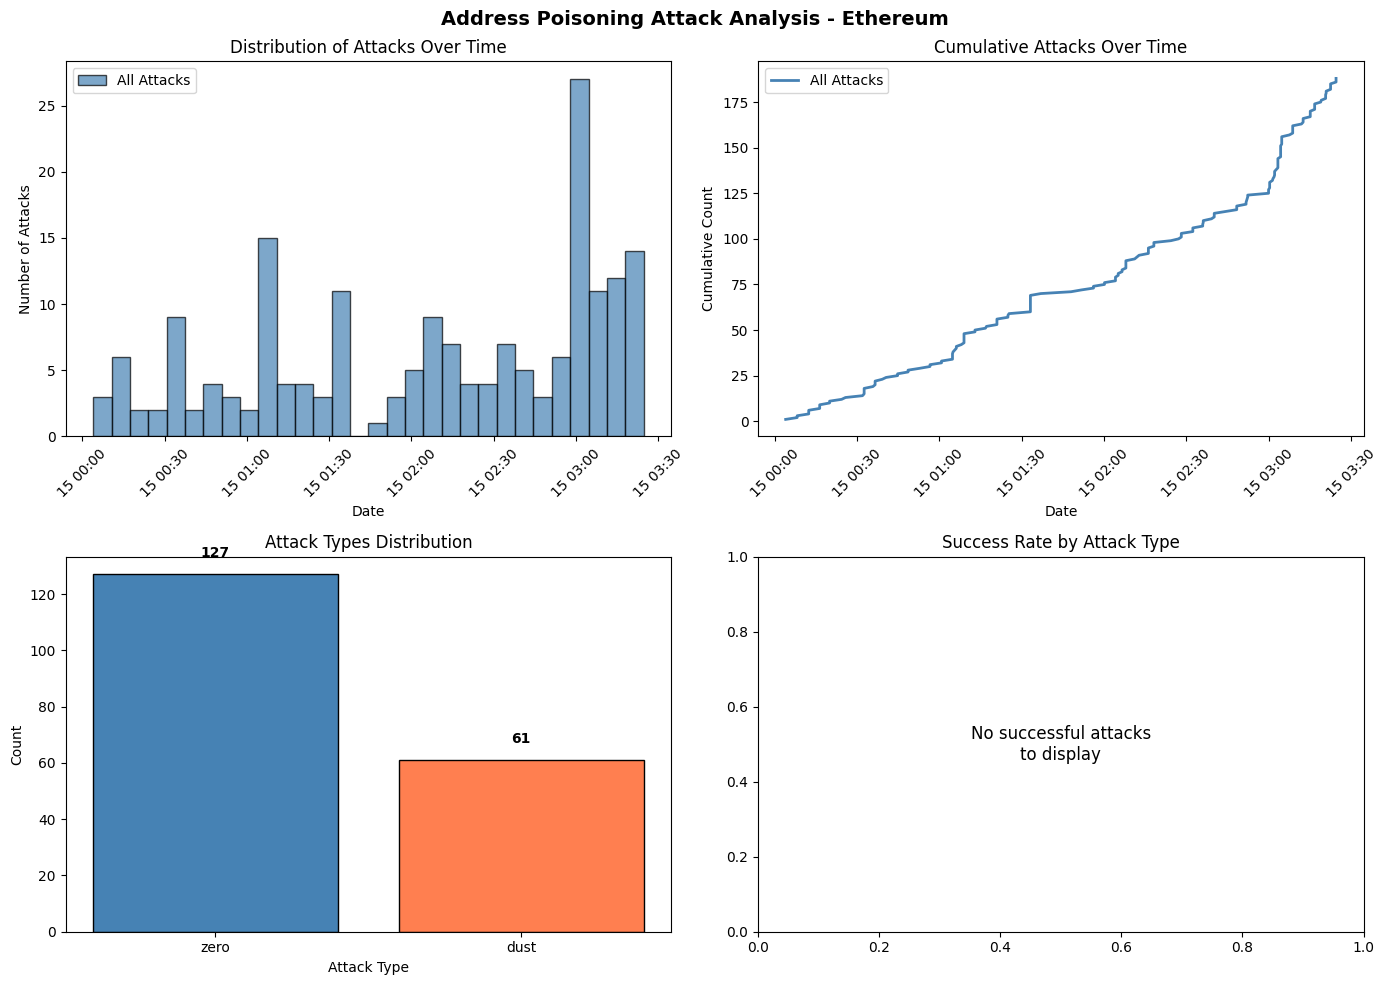

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set up the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Address Poisoning Attack Analysis - Ethereum', fontsize=14, fontweight='bold')

# --- Plot 1: Attacks over time (histogram) ---
ax1 = axes[0, 0]
if 'block_timestamp' in step_5_df.columns:
    ax1.hist(step_5_df['block_timestamp'], bins=30, color='steelblue', edgecolor='black', alpha=0.7, label='All Attacks')
    if len(successful_attacks) > 0:
        ax1.hist(successful_attacks['block_timestamp'], bins=30, color='red', edgecolor='black', alpha=0.7, label='Successful Attacks')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Attacks')
    ax1.set_title('Distribution of Attacks Over Time')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)

# --- Plot 2: Cumulative attacks over time ---
ax2 = axes[0, 1]
if 'block_timestamp' in step_5_df.columns:
    sorted_attacks = step_5_df.sort_values('block_timestamp')
    sorted_attacks['cumulative'] = range(1, len(sorted_attacks) + 1)
    ax2.plot(sorted_attacks['block_timestamp'], sorted_attacks['cumulative'], 
             color='steelblue', linewidth=2, label='All Attacks')
    
    if len(successful_attacks) > 0:
        sorted_success = successful_attacks.sort_values('block_timestamp')
        sorted_success['cumulative'] = range(1, len(sorted_success) + 1)
        ax2.plot(sorted_success['block_timestamp'], sorted_success['cumulative'], 
                 color='red', linewidth=2, label='Successful Attacks')
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Count')
    ax2.set_title('Cumulative Attacks Over Time')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)

# --- Plot 3: Attack types breakdown ---
ax3 = axes[1, 0]
if 'attack_type' in step_5_df.columns:
    attack_types = step_5_df['attack_type'].value_counts()
    colors = ['steelblue', 'coral']
    bars = ax3.bar(attack_types.index, attack_types.values, color=colors[:len(attack_types)], edgecolor='black')
    ax3.set_xlabel('Attack Type')
    ax3.set_ylabel('Count')
    ax3.set_title('Attack Types Distribution')
    
    # Add value labels on bars
    for bar, val in zip(bars, attack_types.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 str(val), ha='center', va='bottom', fontweight='bold')

# --- Plot 4: Success rate by attack type ---
ax4 = axes[1, 1]
if 'attack_type' in step_5_df.columns and len(successful_attacks) > 0:
    # Calculate success rate per attack type
    success_by_type = step_5_df.groupby('attack_type').agg(
        total=('is_successful', 'count'),
        successful=('is_successful', 'sum')
    )
    success_by_type['success_rate'] = (success_by_type['successful'] / success_by_type['total'] * 100)
    
    colors = ['steelblue', 'coral']
    bars = ax4.bar(success_by_type.index, success_by_type['success_rate'], 
                   color=colors[:len(success_by_type)], edgecolor='black')
    ax4.set_xlabel('Attack Type')
    ax4.set_ylabel('Success Rate (%)')
    ax4.set_title('Success Rate by Attack Type')
    ax4.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, val in zip(bars, success_by_type['success_rate']):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'No successful attacks\nto display', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Success Rate by Attack Type')

plt.tight_layout()
plt.show()


In [18]:
# Additional visualization: Value stolen over time (if there are successful attacks)
if len(successful_attacks) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Successful Attack Value Analysis - Ethereum', fontsize=14, fontweight='bold')
    
    # --- Plot 1: Value stolen distribution ---
    ax1 = axes[0]
    ax1.hist(successful_attacks['success_value_usd'], bins=20, color='darkred', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Value Stolen (USD)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Stolen Values')
    ax1.axvline(successful_attacks['success_value_usd'].median(), color='yellow', 
                linestyle='--', linewidth=2, label=f"Median: ${successful_attacks['success_value_usd'].median():,.2f}")
    ax1.legend()
    
    # --- Plot 2: Cumulative value stolen over time ---
    ax2 = axes[1]
    sorted_success = successful_attacks.sort_values('success_timestamp')
    sorted_success['cumulative_value'] = sorted_success['success_value_usd'].cumsum()
    ax2.fill_between(sorted_success['success_timestamp'], sorted_success['cumulative_value'], 
                     color='darkred', alpha=0.5)
    ax2.plot(sorted_success['success_timestamp'], sorted_success['cumulative_value'], 
             color='darkred', linewidth=2)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Value Stolen (USD)')
    ax2.set_title('Cumulative Value Stolen Over Time')
    ax2.tick_params(axis='x', rotation=45)
    
    # Format y-axis as currency
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print(f"\nValue Stolen Statistics:")
    print(f"  Min: ${successful_attacks['success_value_usd'].min():,.2f}")
    print(f"  Max: ${successful_attacks['success_value_usd'].max():,.2f}")
    print(f"  Mean: ${successful_attacks['success_value_usd'].mean():,.2f}")
    print(f"  Median: ${successful_attacks['success_value_usd'].median():,.2f}")
    print(f"  Total: ${successful_attacks['success_value_usd'].sum():,.2f}")
else:
    print("No successful attacks to visualize value data.")


No successful attacks to visualize value data.


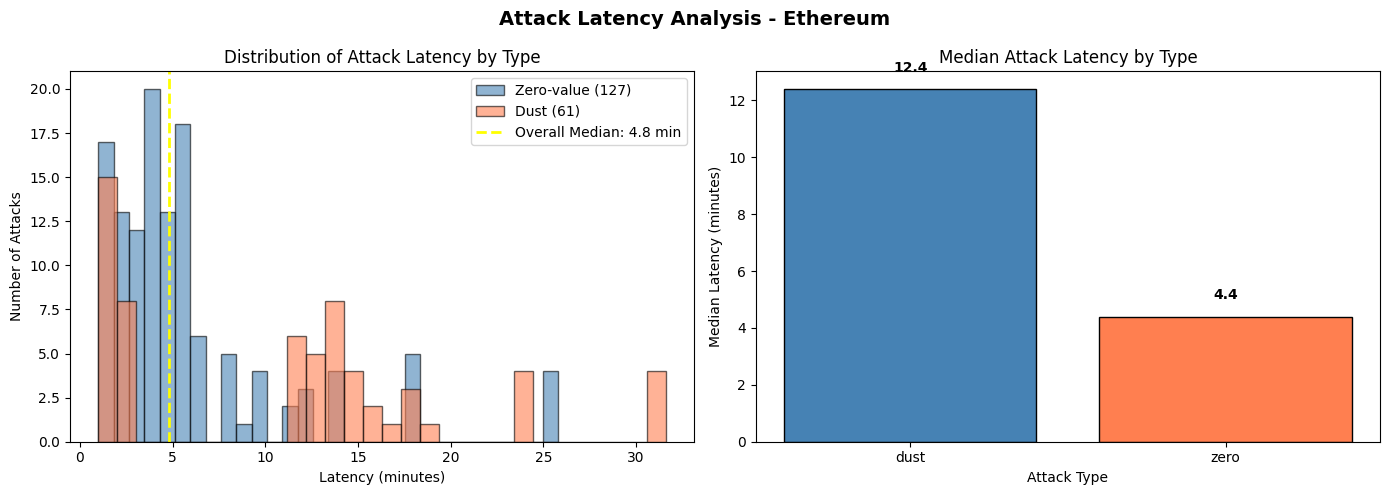


Attack Latency Statistics:
  Overall - Min: 1.00 min, Max: 31.60 min, Median: 4.80 min
  Dust - Min: 1.00 min, Max: 31.60 min, Median: 12.40 min, Count: 61
  Zero - Min: 1.00 min, Max: 25.80 min, Median: 4.40 min, Count: 127


In [19]:
# Attack Latency Analysis - Time between victim transaction and attack
if 'time_since_victim_tx' in step_5_df.columns:
    # Convert timedelta to seconds for plotting
    latency_data = step_5_df[step_5_df['time_since_victim_tx'].notna()].copy()
    latency_data['latency_seconds'] = latency_data['time_since_victim_tx'].dt.total_seconds()
    latency_data['latency_minutes'] = latency_data['latency_seconds'] / 60
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Attack Latency Analysis - Ethereum', fontsize=14, fontweight='bold')
    
    # --- Plot 1: Distribution of attack latency by attack type ---
    ax1 = axes[0]
    if 'attack_type' in latency_data.columns:
        # Get data for each attack type
        zero_data = latency_data[latency_data['attack_type'] == 'zero']['latency_minutes']
        dust_data = latency_data[latency_data['attack_type'] == 'dust']['latency_minutes']
        
        # Plot overlapping histograms
        if len(zero_data) > 0:
            ax1.hist(zero_data, bins=30, color='steelblue', edgecolor='black', alpha=0.6, label=f'Zero-value ({len(zero_data)})')
        if len(dust_data) > 0:
            ax1.hist(dust_data, bins=30, color='coral', edgecolor='black', alpha=0.6, label=f'Dust ({len(dust_data)})')
        ax1.legend()
    else:
        ax1.hist(latency_data['latency_minutes'], bins=30, color='purple', edgecolor='black', alpha=0.7)
    
    ax1.set_xlabel('Latency (minutes)')
    ax1.set_ylabel('Number of Attacks')
    ax1.set_title('Distribution of Attack Latency by Type')
    
    # Add median line
    median_latency = latency_data['latency_minutes'].median()
    ax1.axvline(median_latency, color='yellow', linestyle='--', linewidth=2, 
                label=f'Overall Median: {median_latency:.1f} min')
    ax1.legend()
    
    # --- Plot 2: Latency by attack type (box plot for better distribution view) ---
    ax2 = axes[1]
    if 'attack_type' in latency_data.columns:
        attack_types = latency_data['attack_type'].unique()
        
        # Calculate statistics for each attack type
        stats = []
        for attack_type in attack_types:
            type_data = latency_data[latency_data['attack_type'] == attack_type]['latency_minutes']
            stats.append({
                'type': attack_type,
                'median': type_data.median(),
                'mean': type_data.mean(),
                'min': type_data.min(),
                'max': type_data.max()
            })
        
        stats_df = pd.DataFrame(stats)
        colors = ['steelblue', 'coral']
        bars = ax2.bar(stats_df['type'], stats_df['median'], color=colors[:len(stats_df)], edgecolor='black')
        ax2.set_xlabel('Attack Type')
        ax2.set_ylabel('Median Latency (minutes)')
        ax2.set_title('Median Attack Latency by Type')
        
        # Add value labels
        for bar, val in zip(bars, stats_df['median']):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                     f'{val:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print latency statistics by attack type
    print(f"\nAttack Latency Statistics:")
    print(f"  Overall - Min: {latency_data['latency_minutes'].min():.2f} min, Max: {latency_data['latency_minutes'].max():.2f} min, Median: {latency_data['latency_minutes'].median():.2f} min")
    if 'attack_type' in latency_data.columns:
        for attack_type in latency_data['attack_type'].unique():
            type_data = latency_data[latency_data['attack_type'] == attack_type]['latency_minutes']
            print(f"  {attack_type.capitalize()} - Min: {type_data.min():.2f} min, Max: {type_data.max():.2f} min, Median: {type_data.median():.2f} min, Count: {len(type_data)}")
else:
    print("No latency data available. Make sure to run Step 3 with the updated function.")
